In [13]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']
L_markers = ['s', '^', 'v', 'd', 'P']

In [16]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = [20, 20, 6] # WARNING RooUnfold seg faults if too many bins used
binning = [np.logspace(-5,0,n_bins[0]+1), \
            np.logspace(-4,0,n_bins[1]+1), \
            np.array([5, 20, 40, 60, 80, 100, 150]).astype(float) ]
print(binning)
bincenters = [ get_log_bincenters(binning[0]), get_log_bincenters(binning[1]), get_lin_bincenters(binning[2]) ]
binwidths = [ get_binwidths(a) for a in binning ]

labels = ["energy weight", "$R_L$", "jet $p_T$"]

n_iter = 5

[array([1.00000000e-05, 1.77827941e-05, 3.16227766e-05, 5.62341325e-05,
       1.00000000e-04, 1.77827941e-04, 3.16227766e-04, 5.62341325e-04,
       1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00]), array([1.00000000e-04, 1.58489319e-04, 2.51188643e-04, 3.98107171e-04,
       6.30957344e-04, 1.00000000e-03, 1.58489319e-03, 2.51188643e-03,
       3.98107171e-03, 6.30957344e-03, 1.00000000e-02, 1.58489319e-02,
       2.51188643e-02, 3.98107171e-02, 6.30957344e-02, 1.00000000e-01,
       1.58489319e-01, 2.51188643e-01, 3.98107171e-01, 6.30957344e-01,
       1.00000000e+00]), array([  5.,  20.,  40.,  60.,  80., 100., 150.])]


In [17]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded_closure_new.root")
f_preunfold = ur.open("./preunfold_closure_new.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold["raw"]
h1_raw = f_preunfold["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold["reco"]
h1_true = f_preunfold["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold["gen"]
h1_gen = f_preunfold["gen1D"]

# Data, true [theta_unknown_G]
if closure:
    h3_true = f_preunfold["true"]
    h1_true = f_preunfold["true1D"]

h3_unfolded = []
#h1_unfolded = [] TODO add in h1 unfolded support
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])
    


FileNotFoundError: file not found

    './unfolded_closure_new.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [6]:
# ref: https://hepunx.rl.ac.uk/~adye/software/unfold/htmldoc-dev/src/RooUnfoldResponse.cxx.html#FHDYLE
def FindBin(binx, biny, binz):
    assert binx < n_bins[0] and biny < n_bins [1] and binz < n_bins[2] \
            and 0 <= binx and 0 <= biny and 0 <= binz
    return binx + n_bins[0]*(biny + n_bins[1]*binz)

def FindIndex(bin_n):
    binz = bin_n // (n_bins[0] * n_bins[1])
    bin_n -= binz * (n_bins[0] * n_bins[1])

    biny = bin_n // n_bins[0]
    binx = bin_n % n_bins[0]

    return binx, biny, binz
    

matrix = f_unfolded["matrix"].values()
matrix1D = f_unfolded["matrix1D"].values()

[matrixx, matrixy, matrixz] = [np.zeros((n_bins[i], n_bins[i])) for i in range(3)]

N = n_bins[0]*n_bins[1]*n_bins[2]

for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        for k in range(n_bins[2]):

            reco_bin = FindBin(i, j, k)
            for m in range(N):
                
                binx, biny, binz = FindIndex(m)
                bincontent = matrix[reco_bin][m]

                matrixx[i][binx] += bincontent
                matrixy[j][biny] += bincontent
                matrixz[k][binz] += bincontent

matricies = [matrixx, matrixy, matrixz]


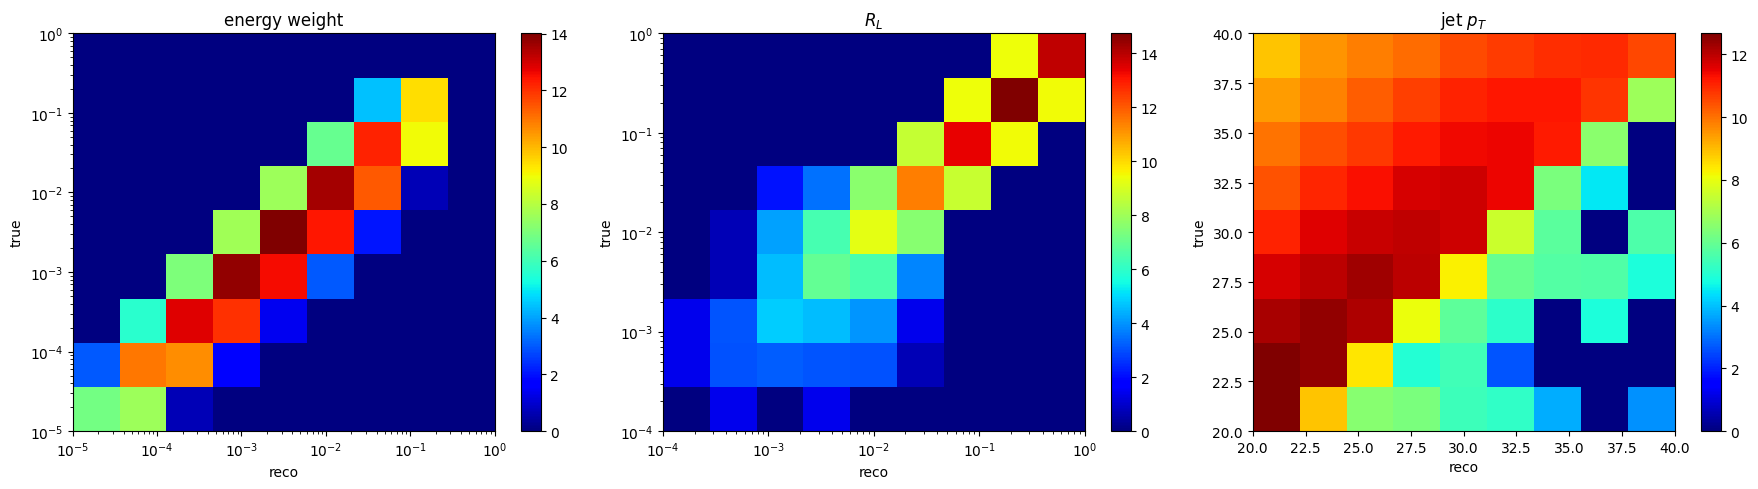

In [7]:
# print response matricies

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax = axes[i]

    # Plot histograms
    #ax.imshow(matrix.values(), origin='lower', extent=[binning[0][0], binning[0][-1], binning[0][0], binning[0][-1]], cmap='viridis')
    h = matricies[i]
    plot = ax.pcolormesh(binning[i], binning[i], np.log(h, out=np.zeros_like(h), where=(h!=0)).T, cmap='jet')
    ax.set_title(labels[i])
    ax.set_xlabel('reco')
    ax.set_ylabel('true')

    if i in [0,1]:
        ax.set_xscale('log')
        ax.set_yscale('log')

    fig.colorbar(plot)


# Show plot
plt.tight_layout()
plt.show()

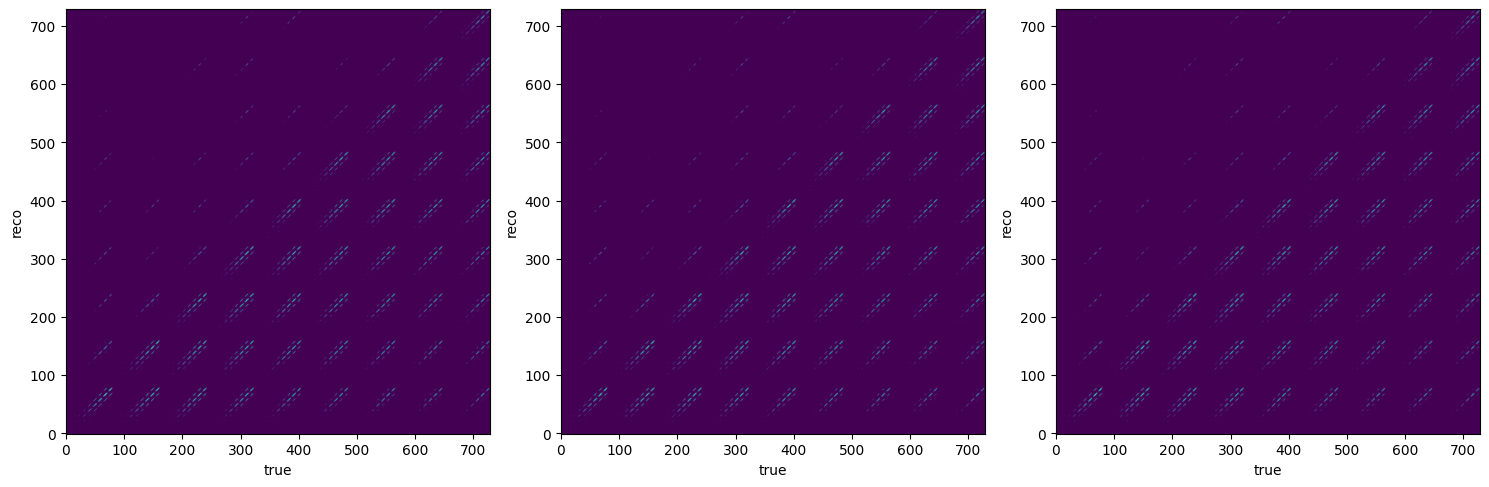

In [8]:
# print response matricies

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axes[i]

    # Plot histograms
    #ax.imshow(matrix.values(), origin='lower', extent=[binning[0][0], binning[0][-1], binning[0][0], binning[0][-1]], cmap='viridis')
    ax.imshow(np.log(matrix, out=np.zeros_like(matrix), where=(matrix!=0)), origin='lower', cmap='viridis')
    ax.set_xlabel('true')
    ax.set_ylabel('reco')
    #ax.set_xscale('log')
    #ax.set_yscale('log')


# Show plot
plt.tight_layout()
plt.show()

In [12]:
proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())]).T
proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())]).T

theta0_G = proj(h3_gen)
theta0_S = proj(h3_reco)
theta_unknown_G = proj(h3_true)
theta_unknown_S = proj(h3_raw)

theta_unfolded = [proj(a) for a in h3_unfolded]

theta0_G_err = proj_err(h3_gen)
theta0_S_err = proj_err(h3_reco)
theta_unknown_G_err = proj_err(h3_true)
theta_unknown_S_err = proj_err(h3_raw)

theta_unfolded_err = [proj_err(a) for a in h3_unfolded]

matrixify = lambda A : projectionXY(A.values()).T
matrixify_err = lambda A: projectionXY(A.errors()).T

U_true = matrixify(h3_true)
U_true_err = matrixify_err(h3_true)

U_unfolded = [matrixify(A) for A in h3_unfolded]
U_unfolded_err = [matrixify_err(A) for A in h3_unfolded]

print(theta0_G)


[[9.968000e+03 2.800000e+01 1.975648e+06]
 [2.989380e+05 1.640000e+02 1.810270e+06]
 [1.443870e+06 6.840000e+02 1.583924e+06]
 [3.084082e+06 3.966000e+03 1.381166e+06]
 [3.431422e+06 2.736000e+04 1.136792e+06]
 [1.962306e+06 2.176040e+05 9.388120e+05]
 [4.502580e+05 1.464718e+06 7.506960e+05]
 [2.449000e+04 6.012250e+06 6.176920e+05]
 [0.000000e+00 2.978560e+06 5.103340e+05]]


In [11]:
# get total number of jets, manually inputted from 1D jet unfolding

N_jets = 39213
N_jets_err = 0

[[9.968000e+03 2.800000e+01 1.975648e+06]
 [2.989380e+05 1.640000e+02 1.810270e+06]
 [1.443870e+06 6.840000e+02 1.583924e+06]
 [3.084082e+06 3.966000e+03 1.381166e+06]
 [3.431422e+06 2.736000e+04 1.136792e+06]
 [1.962306e+06 2.176040e+05 9.388120e+05]
 [4.502580e+05 1.464718e+06 7.506960e+05]
 [2.449000e+04 6.012250e+06 6.176920e+05]
 [0.000000e+00 2.978560e+06 5.103340e+05]]
(9, 3)
[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]
10
(array([2.800000e+01, 1.640000e+02, 6.840000e+02, 3.966000e+03,
       2.736000e+04, 2.176040e+05, 1.464718e+06, 6.012250e+06,
       2.978560e+06]), array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00]), <BarContainer object of 9 artists>)
9
9


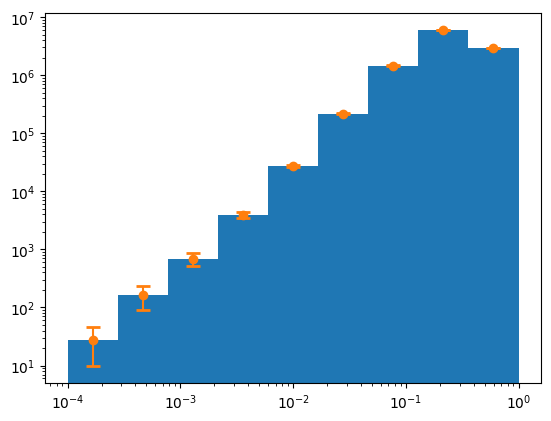

In [12]:
print(theta0_G)
print(theta0_G.shape)
print(binning[1])
print(len(binning[1]))

print(plt.hist(binning[1][:-1], binning[1], weights=theta0_G[:,1]))
print(len(binning[1][:-1]))
print(len(theta0_G_err[:,1]))
plt.errorbar(bincenters[1], theta0_G[:,1], yerr=theta0_G_err[:,1], capsize=5, capthick=2, fmt='o', linestyle="None")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [7]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration][:,1])

[5.45833333e+00 2.15293569e+02 8.21768616e+02 5.55024176e+03
 3.81452816e+04 3.01070420e+05 1.97194640e+06 7.79246142e+06
 3.75552529e+06]
[4.72155444e+00 2.16511398e+02 7.88115895e+02 5.57056222e+03
 3.82446400e+04 3.02503435e+05 1.97720537e+06 7.80844928e+06
 3.76080764e+06]
[4.26215126e+00 2.23034897e+02 7.79135395e+02 5.59354188e+03
 3.82057918e+04 3.02616523e+05 1.97707399e+06 7.80949329e+06
 3.76232938e+06]
[3.95158056e+00 2.31912696e+02 7.84728551e+02 5.61681702e+03
 3.81683378e+04 3.02637063e+05 1.97665723e+06 7.80874459e+06
 3.76253694e+06]
[3.73262438e+00 2.41614527e+02 7.98707258e+02 5.63425245e+03
 3.81365433e+04 3.02661972e+05 1.97636640e+06 7.80816992e+06
 3.76242227e+06]
[3.57331866e+00 2.51366095e+02 8.17515840e+02 5.64497791e+03
 3.81094221e+04 3.02697016e+05 1.97622124e+06 7.80803149e+06
 3.76228959e+06]
[3.45422807e+00 2.60736417e+02 8.38911339e+02 5.65002576e+03
 3.80858972e+04 3.02738833e+05 1.97619247e+06 7.80828068e+06
 3.76222189e+06]
[3.36296608e+00 2.69479152e

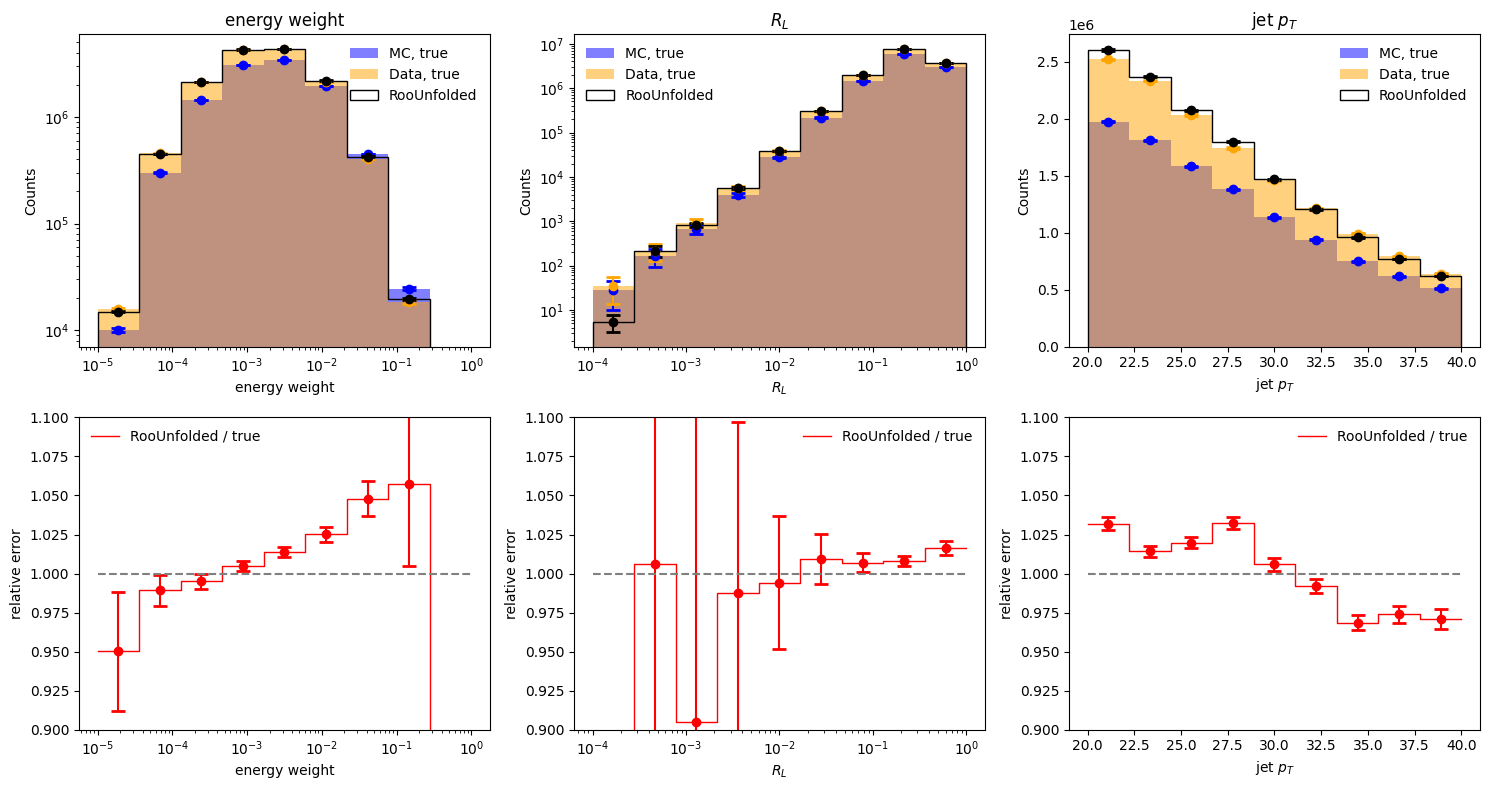

In [8]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

for iteration in range(1):
    fig, axes = plt.subplots(2, 3, figsize=(15,8))

    # ROW 1: raw distributions
    for i in range(3):
        ax = axes[0, i]

        _,_,_=ax.hist(binning[i][:-1], binning[i], weights=theta0_G[:,i],color='blue', alpha=0.5, label="MC, true")
        _,_,_=ax.hist(binning[i][:-1], binning[i], weights=theta_unknown_G[:,i],color='orange',alpha=0.5,label="Data, true")
        _,_,_=ax.hist(binning[i][:-1], binning[i],weights=theta_unfolded[iteration][:,i],color='black',histtype="step",label="RooUnfolded",lw=1)

        ax.errorbar(bincenters[i], theta0_G[:,i], yerr=theta0_G_err[:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color='blue')
        ax.errorbar(bincenters[i], theta_unknown_G[:,i], yerr=theta_unknown_G_err[:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color='orange')
        ax.errorbar(bincenters[i], theta_unfolded[iteration][:,i], yerr=theta_unfolded_err[iteration][:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color='black')
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Counts")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
    
    # ROW 2: residual plots
    for i in range(3):
        ax = axes[1, i]
        
        yvals, yerrs = get_ratio_safe(theta_unfolded[iteration][:,i], theta_unknown_G[:,i], \
                                      numerr=theta_unfolded_err[iteration][:,i], denomerr=theta_unknown_G_err[:,i])
        
        ax.step(binning[i], np.insert(yvals, 0, yvals[0]), where="pre",color='red',label="RooUnfolded / true",lw=1)
        ax.errorbar(bincenters[i], yvals, yerr=yerrs, capsize=5, capthick=2, fmt='o', linestyle="None", color='red')

        ax.hlines(y=1, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_xlabel(labels[i])
        ax.set_ylabel("relative error")
        ax.legend(frameon=False)
        
        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_ylim([0.9, 1.1])
        else:
            ax.set_ylim([0.9, 1.1])

    
    fig.tight_layout()
    # fig.savefig("post_training_" + str(iteration) + ".png")
    # fig.show()
    # plt.close()
plt.show()

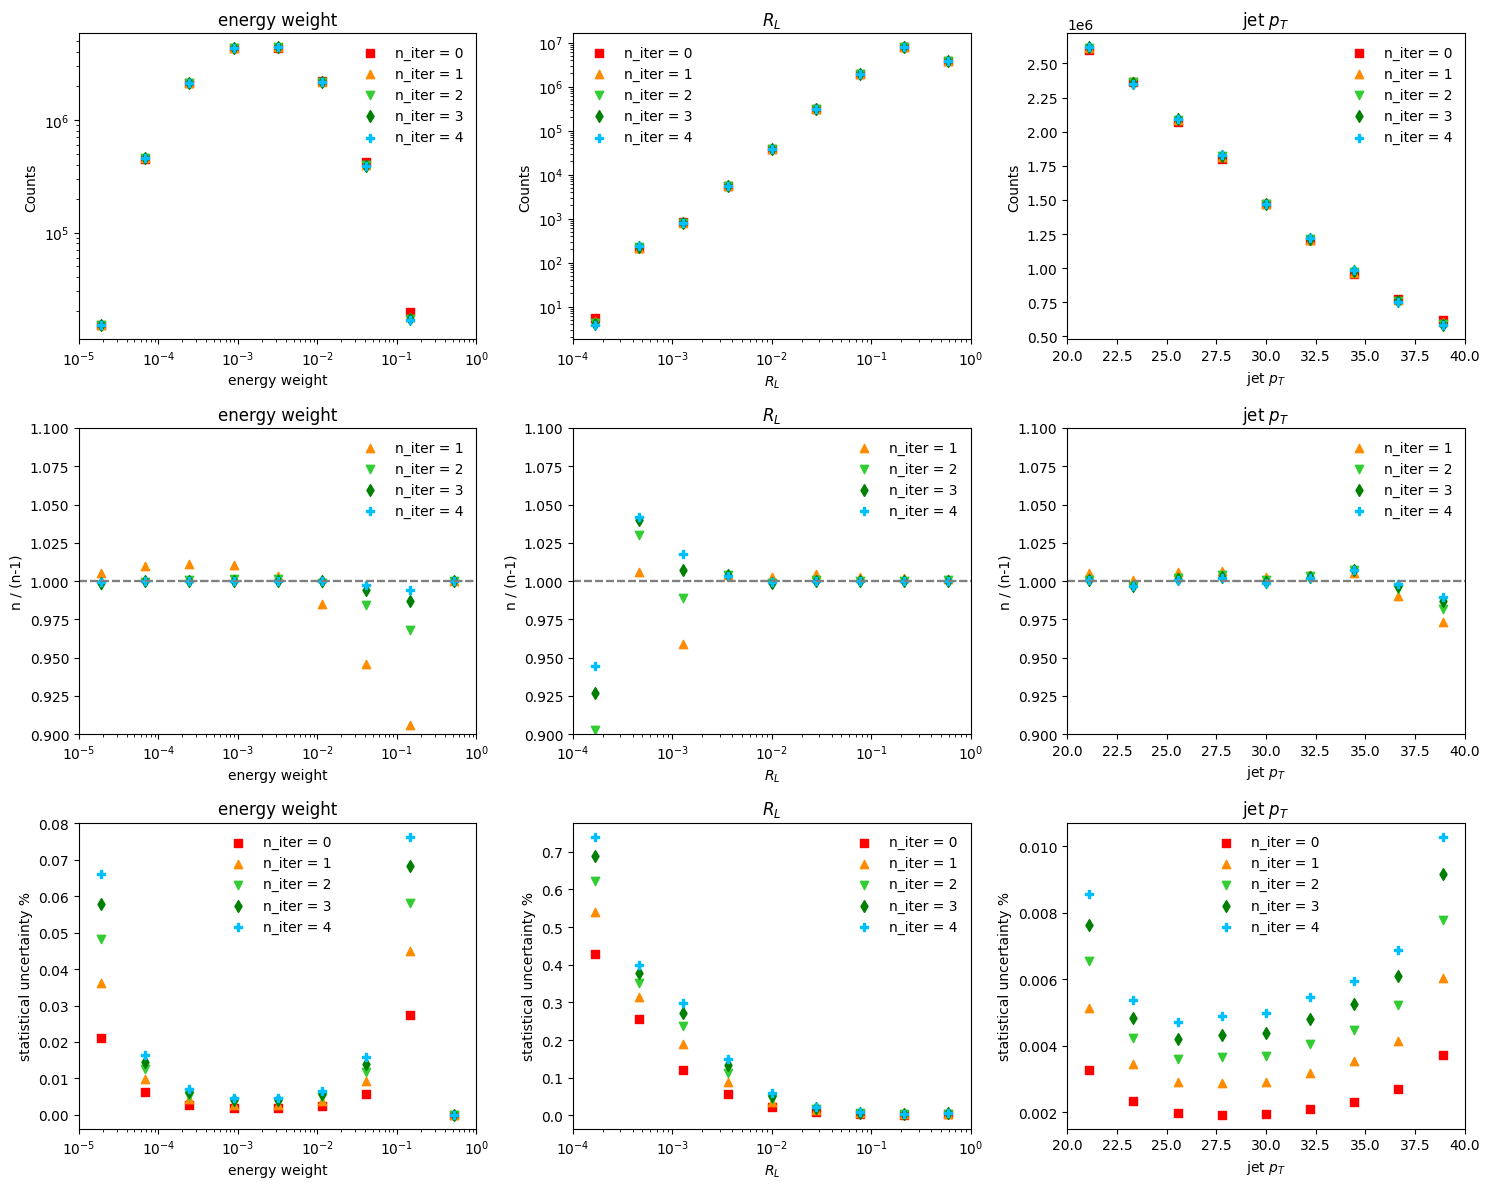

In [9]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

it = 5

fig, axes = plt.subplots(3, 3, figsize=(15,12))

# ROW 1: raw distributions
for i in range(3):
    ax = axes[0, i]

    for iteration in range(it):
        ax.scatter(bincenters[i], theta_unfolded[iteration][:,i],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
        ax.set_ylabel("Counts")

        #ax.errorbar(bincenters[i], theta_unfolded[iteration][:,i], yerr=theta_unfolded_err[iteration][:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color=L_colors[iteration])
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 2: convergence plot (n / n - 1)
for i in range(3):
    ax = axes[1, i]

    for iteration in range(1,it):
    
        yvals = safe_divide(theta_unfolded[iteration][:,i] , theta_unfolded[iteration-1][:,i], filler=1)
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.hlines(y=1, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("n / (n-1)")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_ylim([0.9, 1.1])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 3: statistical error %
for i in range(3):
    ax = axes[2, i]

    for iteration in range(it):
        
        yvals = safe_divide(theta_unfolded_err[iteration][:,i], theta_unfolded[iteration][:,i])
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("statistical uncertainty %")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


fig.tight_layout()
plt.show()

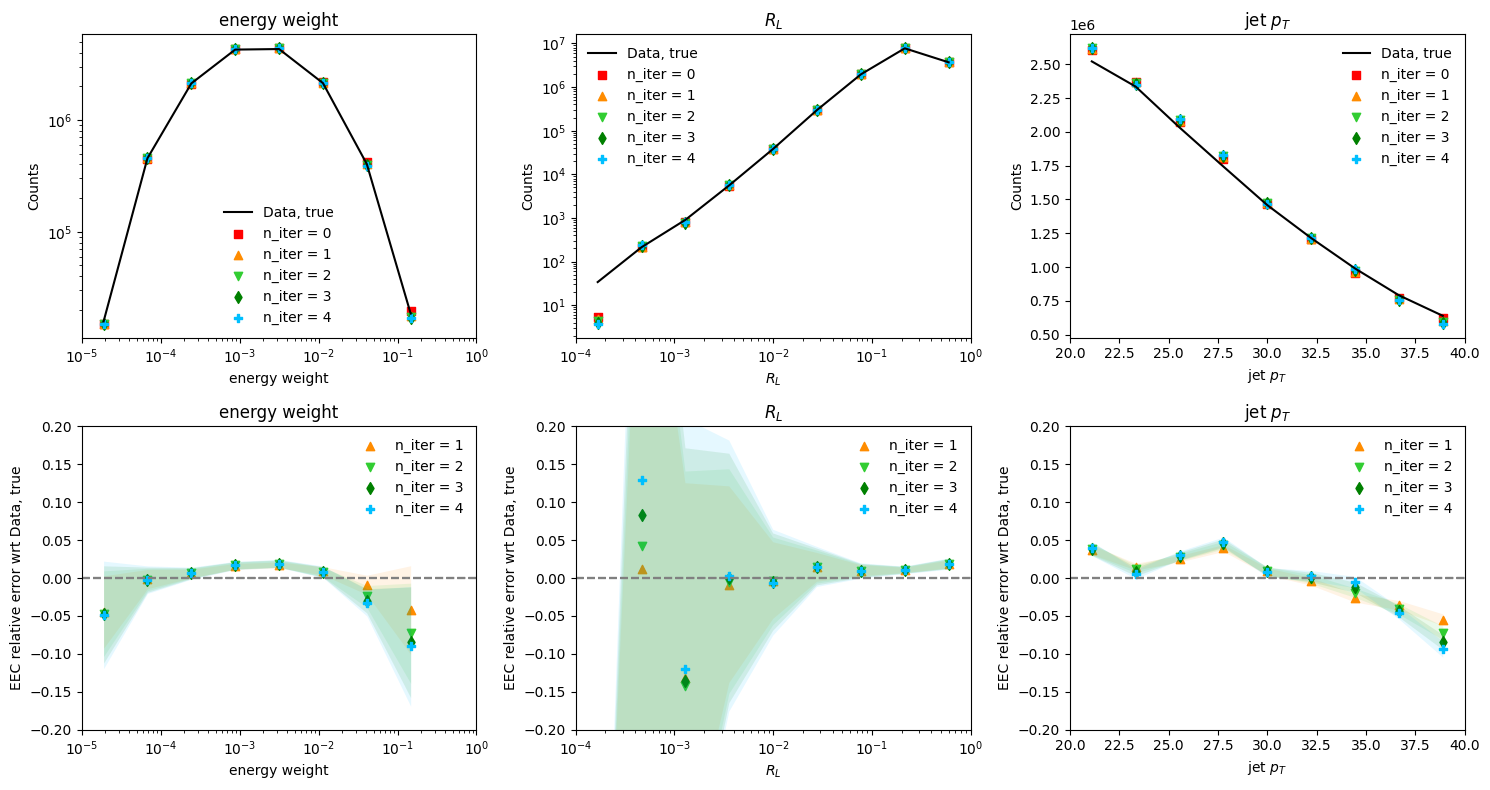

In [10]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

it = 5

fig, axes = plt.subplots(2, 3, figsize=(15,8))

# ROW 1: raw distributions
for i in range(3):
    ax = axes[0, i]

    if i == 0:
        ax.plot(bincenters[i][:-1], theta_unknown_G[:,i][:-1], color='black',label="Data, true")
    else:
        ax.plot(bincenters[i], theta_unknown_G[:,i], color='black',label="Data, true")

    for iteration in range(it):
        ax.scatter(bincenters[i], theta_unfolded[iteration][:,i],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
        ax.set_ylabel("Counts")

        #ax.errorbar(bincenters[i], theta_unfolded[iteration][:,i], yerr=theta_unfolded_err[iteration][:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color=L_colors[iteration])
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 2: error wrt Data, true
for i in range(3):
    ax = axes[1, i]

    for iteration in range(1,it):

        yvals, yerrs = get_ratio_safe(theta_unfolded[iteration][:,i], theta_unknown_G[:,i], \
                                      numerr=theta_unfolded_err[iteration][:,i], denomerr=theta_unknown_G_err[:,i])
        yvals = yvals - 1

        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        if i == 0:
            ax.fill_between(bincenters[i][:-1], (yvals-yerrs)[:-1], (yvals+yerrs)[:-1], alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)
        else:
            ax.fill_between(bincenters[i], yvals-yerrs, yvals+yerrs, alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)

        ax.hlines(y=0, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("EEC relative error wrt Data, true")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_ylim([-0.2, 0.2])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])

fig.tight_layout()
plt.show()


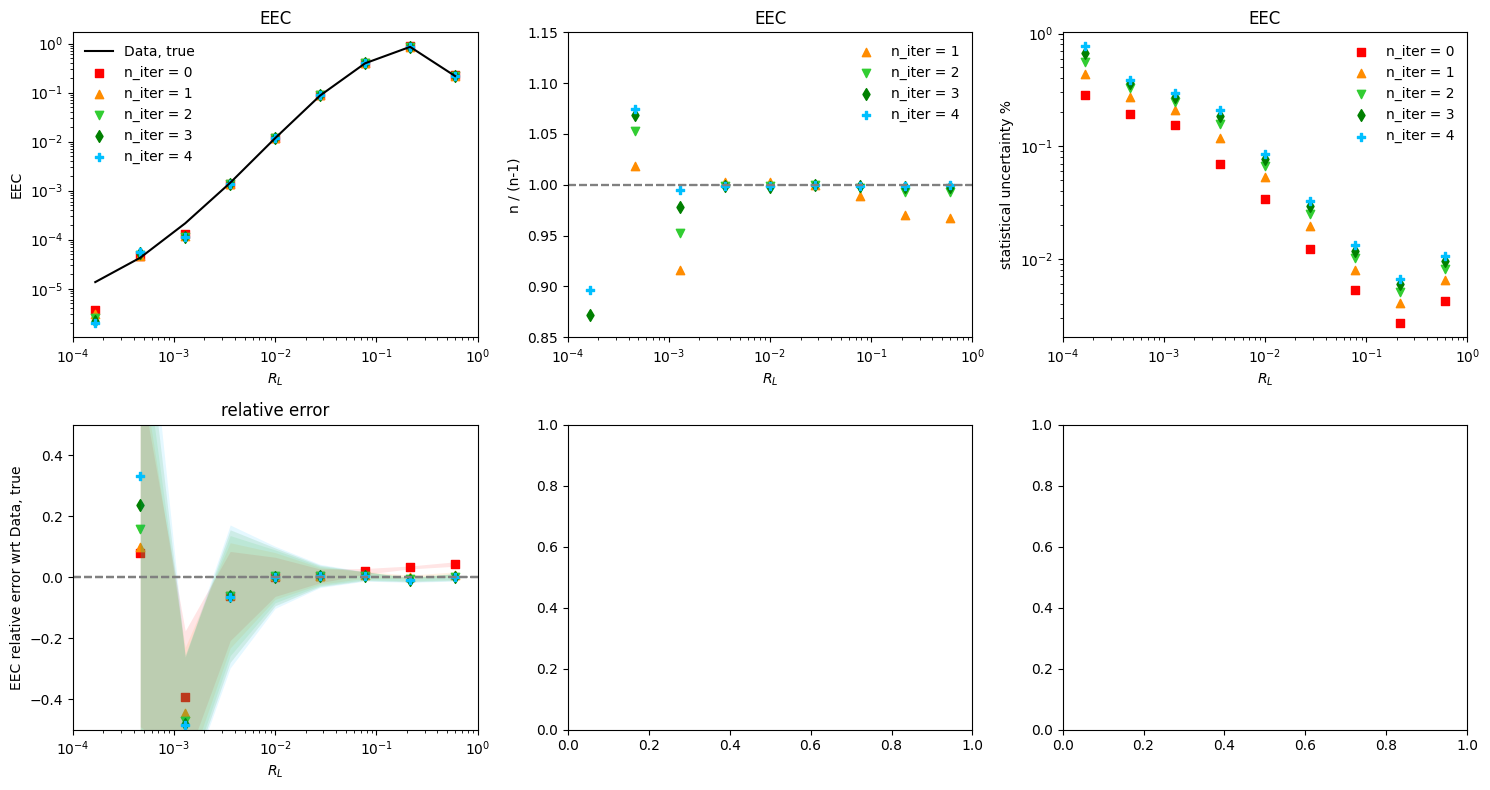

In [49]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 5

fig, axes = plt.subplots(2, 3, figsize=(15,8))

# EEC weight calculation:
# w_n = U * b, U is matrixfied RL-energy weight 2D histogram, b is bincenters of energy weights

true_EEC = np.array([np.dot(col, bincenters[0]) for col in U_true]) / N_jets
true_EEC_err = np.array([np.dot(col, bincenters[0]) for col in U_true_err]) / N_jets

unfolded_EEC = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets
unfolded_EEC_err = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_err[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets

# COL 1: raw EEC distribution WITH relative error over data, true underneath
ax = axes[0, 0]

rl_lims = ax.set_xlim([binning[1][0], binning[1][len(binning[1])-1]])

ax.plot(bincenters[1], true_EEC, color='black',label="Data, true")

for iteration in range(it):

    ax.scatter(bincenters[1], unfolded_EEC[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("EEC")
    
    ax.set_title("EEC")
    ax.set_xlabel(labels[1])

    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)

# row below with the error

ax = axes[1, 0]

ax.hlines(y=0, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

for iteration in range(it):

    yvals, yerrs = get_ratio_safe(unfolded_EEC[iteration], true_EEC, \
                                      numerr=unfolded_EEC_err[iteration], denomerr=true_EEC_err, filler=1)
    yvals = yvals - 1

    ax.scatter(bincenters[1][1:], yvals[1:], color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.fill_between(bincenters[1][1:], (yvals-yerrs)[1:], (yvals+yerrs)[1:], alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)

    ax.hlines(y=0, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')
    

    ax.set_title("relative error")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("EEC relative error wrt Data, true")

    ax.set_xscale('log')
    ax.set_ylim([-0.5, 0.5])
    ax.set_xlim(rl_lims)


# COL 2: convergence plot (n / n - 1)
ax = axes[0, 1]

for iteration in range(1,it):

    yvals = safe_divide(unfolded_EEC[iteration], unfolded_EEC[iteration-1], filler=1)
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_ylim([0.85, 1.15])
    ax.set_xlim(rl_lims)


# COL 3: statistical error %
ax = axes[0, 2]

for iteration in range(it):
    
    yvals = safe_divide(unfolded_EEC_err[iteration], unfolded_EEC[iteration])
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("statistical uncertainty %")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)


fig.tight_layout()
plt.show()
